In [1]:
from utilities import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X_train, y_train, X_test, y_test = load_data()

In [3]:
print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train, return_counts=True))

(1000, 64, 64)
(1000, 1)
(array([0., 1.]), array([500, 500], dtype=int64))


In [4]:
print(X_test.shape)
print(y_test.shape)
print(np.unique(y_test, return_counts=True))

(200, 64, 64)
(200, 1)
(array([0., 1.]), array([100, 100], dtype=int64))


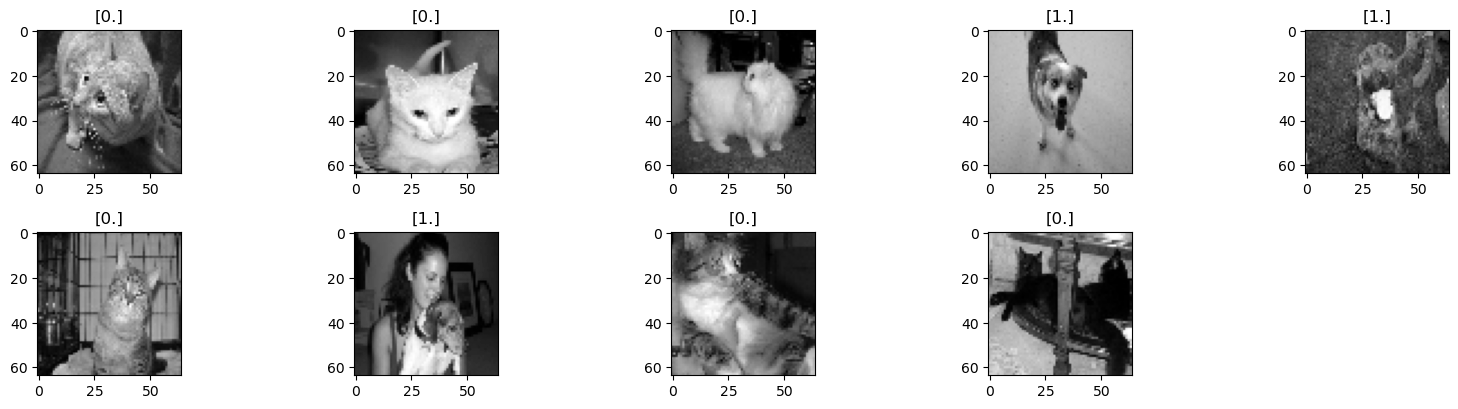

In [5]:
plt.figure(figsize=(16, 8))
for i in range(1, 10):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

In [6]:
# TO DO
# 1. Normaliser le train_set et le test_set (0-255 -> 0-1)
# 2. flatten() les variables du train_set et du test_set (64x64 -> 4096)
# 3. Entrainer le modele sur le train_set (tracer la courbe d'apprentissage, trouver les bons hyper-params)
# (si vous rencontrez un probleme avec le log_loss, utiliser la fonction de sklearn a la place !)
# 4. Évaluer le modele sur le test_set (tracer également la courbe de Loss pour le test_set)
# 5. Partager vos conclusions dans les commentaires !

In [7]:
def flatten_and_normalize_data(X, X_train):
    # Aplatir les données
    X = X.T
    X_flattened = X.reshape(-1, X.shape[-1])/ X_train.max()
    return X_flattened

X_train = flatten_and_normalize_data(X_train, X_train)
X_test = flatten_and_normalize_data(X_test, X_train)

y_train = y_train.T
y_test = y_test.T

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4096, 1000)
(4096, 200)
(1, 1000)
(1, 200)


In [8]:
# mettre à jour les dimensions

def initialisation(n0, n1, n2):

    W1 = np.random.randn(n1, n0)
    b1 = np.zeros((n1, 1))
    W2 = np.random.randn(n2, n1)
    b2 = np.zeros((n2, 1))

    parametres = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }

    return parametres

In [9]:
from scipy.special import expit
# Utile pour Optuna (plus stable numériquement, évite les débordements par valeur trop grande/ trop petite)

def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = W1.dot(X) + b1
    A1 = expit(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = expit(Z2)

    activations= {
        'A1' : A1,
        'A2' : A2
    }

    return activations

In [10]:
def back_propagation(X, y, parametres, activations):

    A1 = activations['A1']
    A2 = activations['A2']
    W2 = parametres['W2']

    m = y.shape[1]

    dZ2 = A2 - y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims = True)

    dZ1 = np.dot(W2.T, dZ2) * A1 * (1 - A1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {
        'dW1' : dW1,
        'db1' : db1,
        'dW2' : dW2,
        'db2' : db2
    }

    return gradients

In [11]:
def update(gradients, parametres, learning_rate):

    W1 = parametres['W1']
    b1 = parametres['b1']
    W2 = parametres['W2']
    b2 = parametres['b2']

    dW1 = gradients['dW1']
    db1 = gradients['db1']
    dW2 = gradients['dW2']
    db2 = gradients['db2']

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parametres = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }

    return parametres

In [12]:
def predict(X, parametres):
  activations = forward_propagation(X, parametres)
  A2 = activations['A2']
  return A2 >= 0.5

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from tqdm import tqdm

In [25]:
def neural_network(X_train, y_train, X_test, y_test, n1, learning_rate = 0.01, n_iter = 15000):

    # initialisation parametres
    n0 = X_train.shape[0]
    n2 = y_train.shape[0]
    np.random.seed(0)
    parametres = initialisation(n0, n1, n2)

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    # gradient descent
    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X_train, parametres)
        A2 = activations['A2']

        if i % 10 == 0 :
            train_loss.append(log_loss(y_train.flatten(), A2.flatten()))
            y_pred = predict(X_train, parametres)
            train_acc.append(accuracy_score(y_train.flatten(), y_pred.flatten()))

            activations_test = forward_propagation(X_test, parametres)
            A2_test = activations_test['A2']
            test_loss.append(log_loss(y_test.flatten(), A2_test.flatten()))
            y_pred_test = predict(X_test, parametres)
            test_acc.append(accuracy_score(y_test.flatten(), y_pred_test.flatten()))

        # mise a jour
        gradients = back_propagation(X_train, y_train, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train acc')
    plt.plot(test_acc, label='test_acc')
    plt.legend()
    plt.show()

    return parametres

100%|██████████| 15000/15000 [04:37<00:00, 54.02it/s]


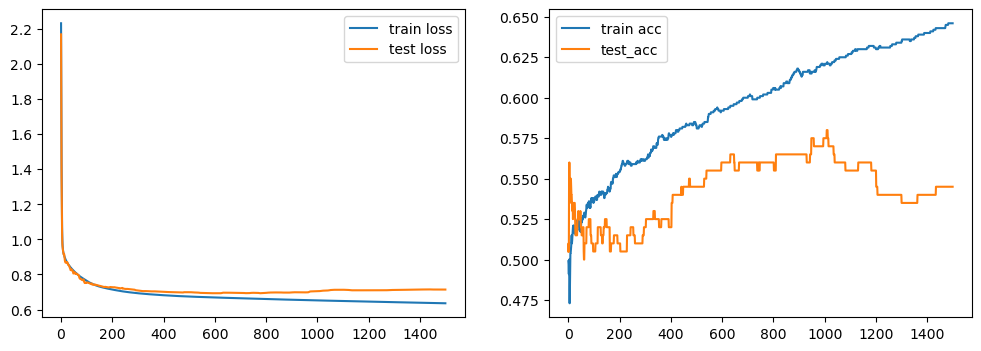

In [26]:
n1 = 32

parameters = neural_network(X_train, y_train,X_test, y_test, n1)